In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from enum import Enum

import matplotlib.pyplot as plt
from sklearn import linear_model
import scipy as sp
import statsmodels.api as sm

import seaborn as sns

In [32]:
data.head(5)

,PType,Age,Gender,Education,Answer
0,ÇDÜY,1,1,3,"[SCORETYPE.SEZGISEL, SCORETYPE.DISADONUK, SCOR..."
1,ÇDÜY,1,0,2,"[SCORETYPE.DUYUSAL, SCORETYPE.ICEDONUK, SCORET..."
2,ŞDÜY,1,0,2,"[SCORETYPE.SEZGISEL, SCORETYPE.ICEDONUK, SCORE..."
3,ŞSÜY,1,1,2,"[SCORETYPE.SEZGISEL, SCORETYPE.DISADONUK, SCOR..."
4,ÇSUY,2,1,3,"[SCORETYPE.SEZGISEL, SCORETYPE.DISADONUK, SCOR..."


<h1> ENUMS TO CODE DATA </h1>

In [113]:


# ENUMS:
class AgeRange(Enum):
    MINUS18 = 0
    B2130 = 1
    B3140 = 2
    B4150 = 3
    PLUS50 = 4

class Education(Enum):
    HSCHOOL = 0
    JCOLLEGE = 1
    UNIVERSITY = 2
    MASTERS = 3
    PHD = 4
    OTHER = 5
    
class Gender(Enum):
    MALE = 0
    FEMALE = 1

class SCORETYPE(Enum):
    ICEDONUK = 0
    DISADONUK = 1
    DUYUSAL = 2
    SEZGISEL = 3
    DUSUNSEL = 4
    DUYGUSAL = 5
    YARGISAL = 6
    ALGISAL = 7

<h1> CLEAN DATA </h1>

In [114]:
data = pd.read_csv("kpa-data.csv", sep=";", names = ["PType", "Age", "Gender", "Education", "Answer"]);

# Remove First 3 rows
for dataIndex in range(3):
    data = data.drop([dataIndex])
data = data.reset_index(drop = True)

dataRowCount = data.shape[0]

#Remove commas from answer column
for row in range(dataRowCount):
    data["Answer"][row] = data["Answer"][row].replace(",", "")

# Convert String Labels to Enums
for row in range(dataRowCount):
    if data["Age"][row] == "21-30":
        data["Age"][row] = AgeRange.B2130.value
    elif data["Age"][row] == "31-40":
        data["Age"][row] = AgeRange.B3140.value
    elif data["Age"][row] == "41-50":
        data["Age"][row] = AgeRange.B4150.value
    elif data["Age"][row] == "20 ve altı":
        data["Age"][row] = AgeRange.MINUS18.value
    elif data["Age"][row] == "50 ve yukarısı":
        data["Age"][row] = AgeRange.PLUS50.value

for row in range(dataRowCount):
    if data["Education"][row] == "Lise":
        data["Education"][row] = Education.HSCHOOL.value
    elif data["Education"][row] == "Yüksek Okul (2 yıl)":
        data["Education"][row] = Education.JCOLLEGE.value
    elif data["Education"][row] == "Üniversite":
        data["Education"][row] = Education.UNIVERSITY.value
    elif data["Education"][row] == "Yüksek Lisans":
        data["Education"][row] = Education.MASTERS.value
    elif data["Education"][row] == "Doktora":
        data["Education"][row] = Education.PHD.value
    elif data["Education"][row] == "Lise öncesi":
        data["Education"][row] = Education.OTHER.value
        
for row in range(dataRowCount):
    if data["Gender"][row] == "Erkek":
        data["Gender"][row] = Gender.MALE.value
    elif data["Gender"][row] == "Kadın":
        data["Gender"][row] = Gender.FEMALE.value

In [115]:
dataRowCount = data.shape[0]
newAnswerTotal = []
for row in range(dataRowCount):
    newAnswer = []
    for choice in range(len(data["Answer"][0])):
        if data["Answer"][row][choice] == "a":
            newAnswer.append(answerSheet[choice + 1][0])
        else:
            newAnswer.append(answerSheet[choice + 1][1])
    newAnswerTotal.append(newAnswer)

for row in range(dataRowCount):
    data["Answer"][row] = newAnswerTotal[row]

<h1> K-Means </h1>

In [116]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [117]:
finalPoints = getUserPoints()
df = pd.DataFrame(finalPoints, columns=['disIc', 'duySez', 'dusDuy', 'yarAl'])
kMeans, pred = applyKMeans(16, df)

predictedType = np.asarray(pred['cluster'])
trueType = np.asarray(data['PType'])
pd.DataFrame({"Predicted" : predictedType, "Actual" : trueType})

,Predicted,Actual
0,7,ÇDÜY
1,1,ÇDÜY
2,0,ŞDÜY
3,0,ŞSÜY
4,2,ÇSUY
...,...,...
157,8,ŞSÜY
158,5,ÇSÜA
159,12,ÇDÜA
160,15,ÇSÜY


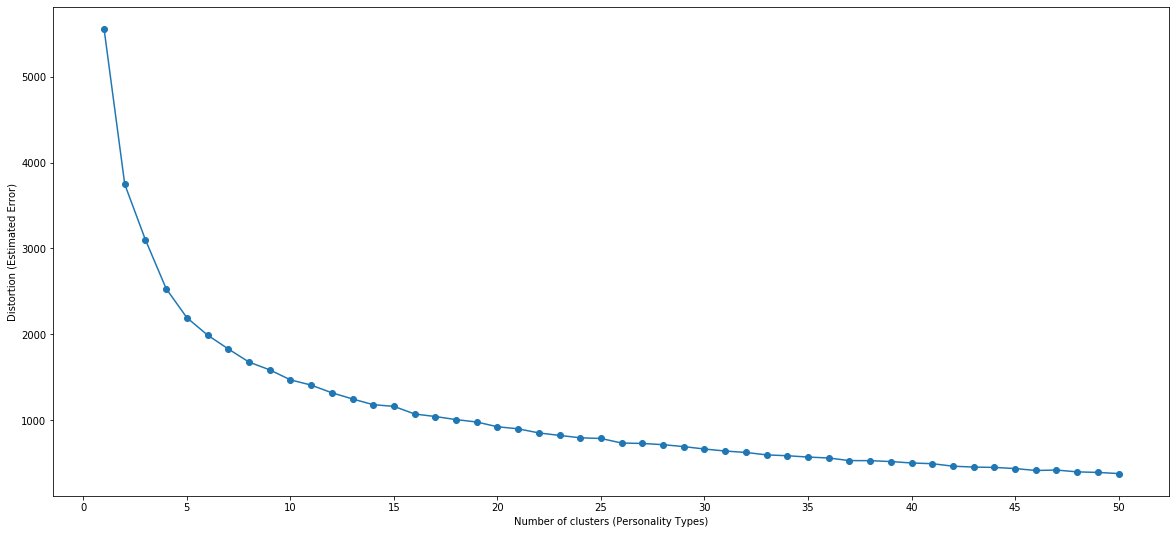

In [109]:
# Calculate Distortion
distortions = []
for clusterSize in range(1,51):
    distortions.append(applyKMeans(clusterSize, df)[0].inertia_)
    
f, ax = plt.subplots(figsize=(20, 9))

plt.plot(range(1,51), distortions, marker = 'o')
plt.xticks(np.arange(0, 51, 5))
plt.xlabel('Number of clusters (Personality Types)')
plt.ylabel('Distortion (Estimated Error)')
plt.show()

f.savefig("kmeans.png")

In [45]:
def applyKMeans(clusterSize, data):
    kmeans = KMeans(n_clusters=clusterSize, init='k-means++', n_init=10, max_iter=1000, tol=1e-04)
    y = kmeans.fit_predict(data[['disIc', 'duySez', 'dusDuy', 'yarAl']])
    data['cluster'] = y
    return (kmeans, data)

In [107]:
def getUserPoints():
    dataRowCount = data.shape[0]
    finalPoints = []
    for row in range(dataRowCount):
        disIcPoint = 0
        duySezPoint = 0
        dusDuyPoint = 0
        yarAlPoint = 0
        for questionNumber in range(32):
            disIcPoint, duySezPoint, dusDuyPoint, yarAlPoint = getPointForScoreType(data.Answer[row][questionNumber], disIcPoint, duySezPoint, dusDuyPoint, yarAlPoint)
        finalPoints.append([disIcPoint, duySezPoint, dusDuyPoint, yarAlPoint])
    return finalPoints

In [105]:
def getPointForScoreType(retrievedScoreType, disIcPoint, duySezPoint, dusDuyPoint, yarAlPoint):
    if retrievedScoreType.value == SCORETYPE.ICEDONUK.value:
        disIcPoint += 1
    elif retrievedScoreType.value == SCORETYPE.DISADONUK.value:
        disIcPoint -= 1
    elif retrievedScoreType.value == SCORETYPE.DUYUSAL.value:
        duySezPoint += 1
    elif retrievedScoreType.value == SCORETYPE.SEZGISEL.value:
        duySezPoint -= 1
    elif retrievedScoreType.value == SCORETYPE.DUSUNSEL.value:
        dusDuyPoint += 1
    elif retrievedScoreType.value == SCORETYPE.DUSUNSEL.value:
        dusDuyPoint -= 1
    elif retrievedScoreType.value == SCORETYPE.YARGISAL.value:
        yarAlPoint += 1
    elif retrievedScoreType.value == SCORETYPE.ALGISAL.value:
        yarAlPoint -= 1
    return disIcPoint, duySezPoint, dusDuyPoint, yarAlPoint

<h1> CALCULATE CORRELATION AND PLOT IT </h1>

In [125]:
dataRowCount = data.shape[0]
correlations = []
for questionNumber in range(32):
    firstScoreType = answerSheet[questionNumber + 1][0]
    secondScoreType = answerSheet[questionNumber + 1][1]
    correlations.append(findCorrelationBetweenQuestionAndScore(questionNumber, firstScoreType, secondScoreType))


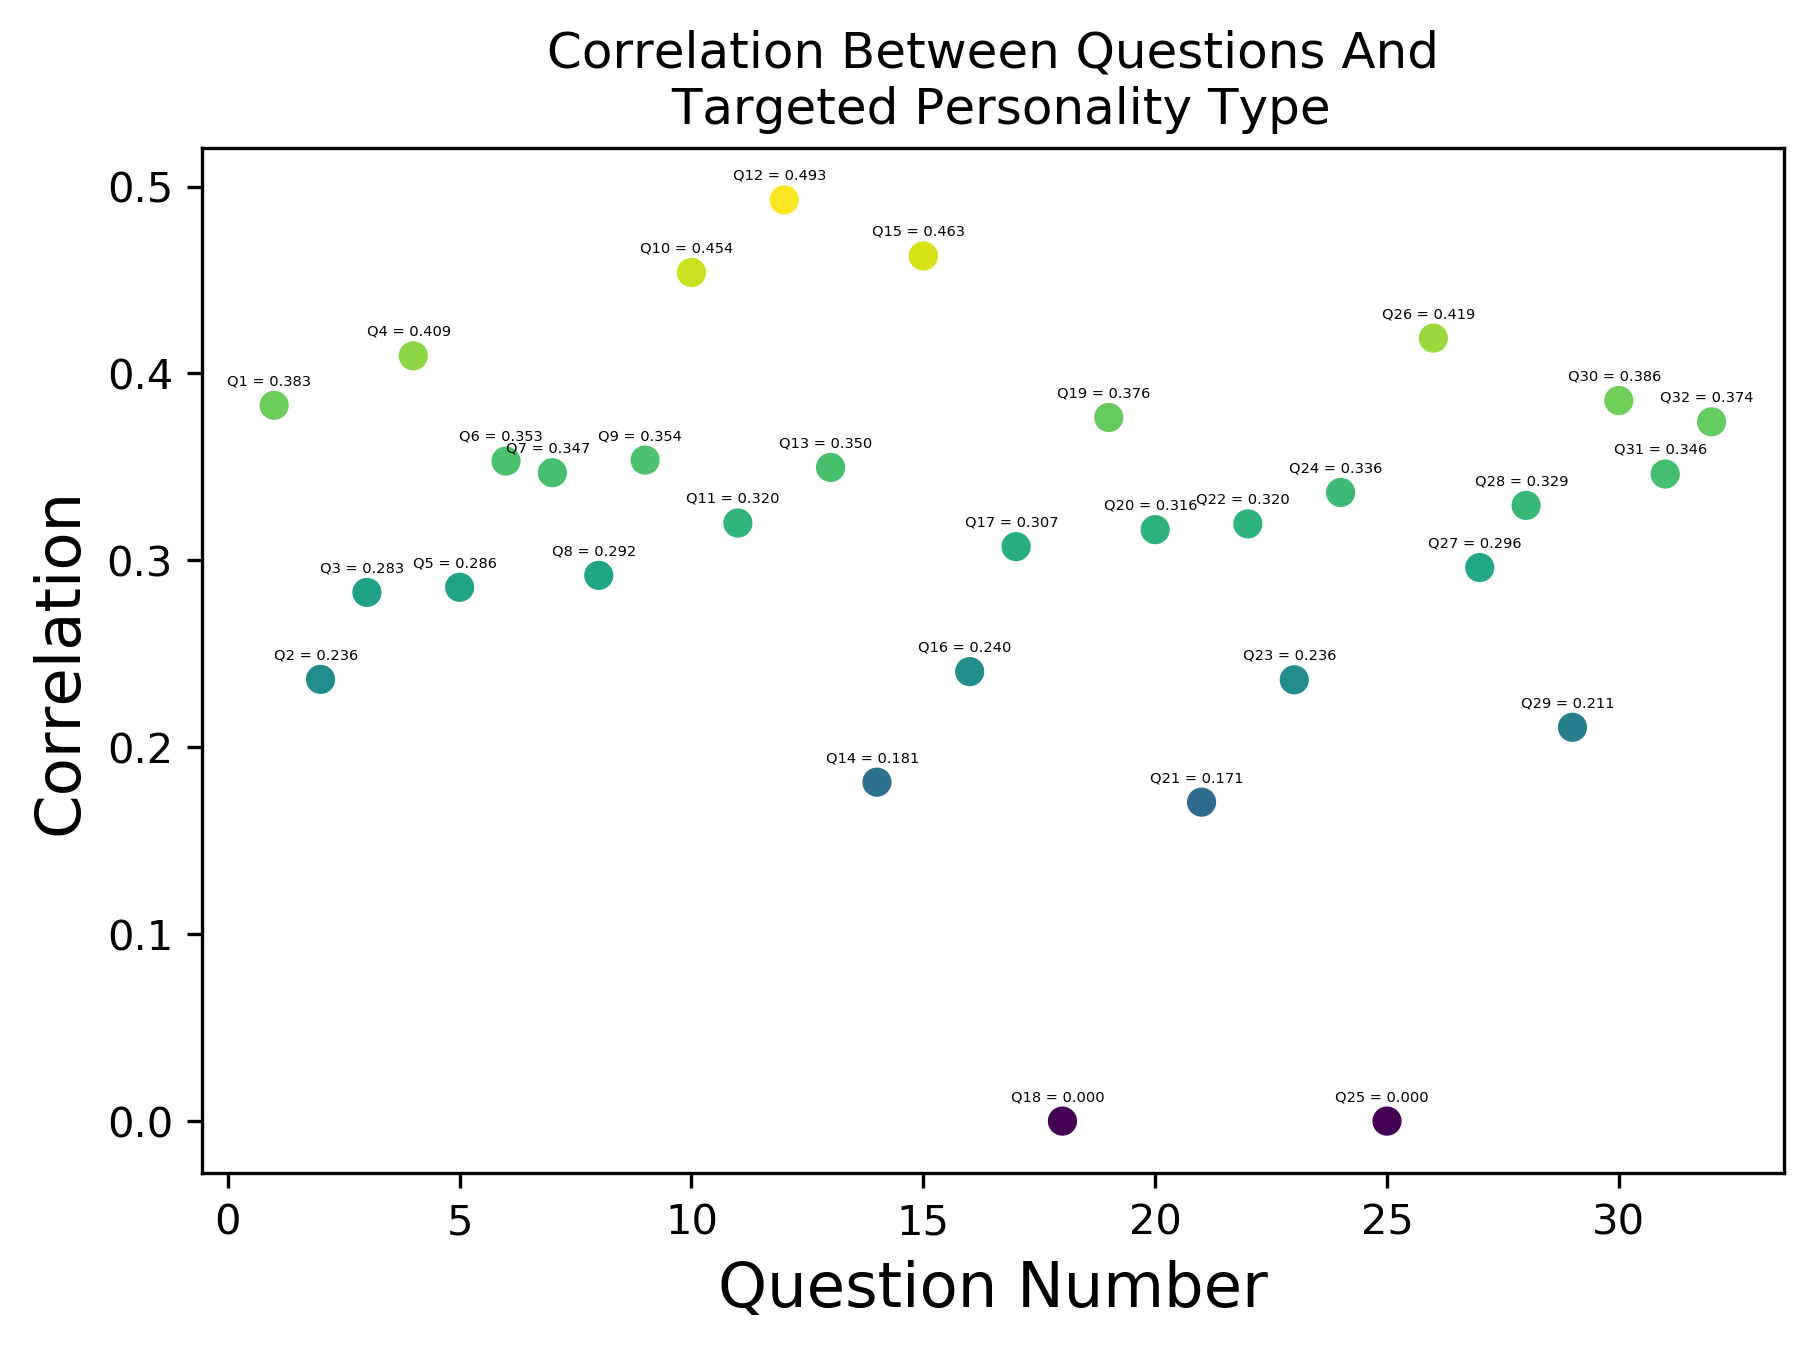

In [127]:
fig, ax = plt.subplots()
fig.facecolor = "w"
fig.edgecolr = "k"
fig.dpi = 300
fig.figsize = figsize=(8, 6)
fig.tight_layout()
ax.set_xlabel("Question Number", fontsize=15)
ax.set_ylabel('Correlation', fontsize=15)

ax.set_title('Correlation Between Questions And\n Targeted Personality Type')

scatterColor = correlations
plt.scatter(range(1,33), correlations, c = scatterColor)
for questionNumber in range(32):
    correlation2Digit = "{0:.3f}".format(correlations[questionNumber])
    plt.annotate(f"Q{questionNumber + 1} = {correlation2Digit}",(questionNumber,correlations[questionNumber]), textcoords="offset points",xytext=(10,5), ha='center', fontsize = 3.5) 
    # plt.text(questionNumber, correlations[questionNumber], f"Q{questionNumber} = {correlation2Digit}")



plt.show()
fig.savefig('Correlation Between Questions And\n Targeted Personality Type.png', bbox_inches='tight')

<h1>Correlation Between Factors</h1>

In [128]:
userPoints = getUserPoints()
icDis = []
duySez = []
dusDuy = []
yarAl = []
for rowNumber in range(len(userPoints)):
    icDis.append(userPoints[rowNumber][0])
    duySez.append(userPoints[rowNumber][1])
    dusDuy.append(userPoints[rowNumber][2])
    yarAl.append(userPoints[rowNumber][3])

df = pd.DataFrame(userPoints, columns= ["İçe Dönük", "Duyusal", "Düşünsel", "Yargısal"])

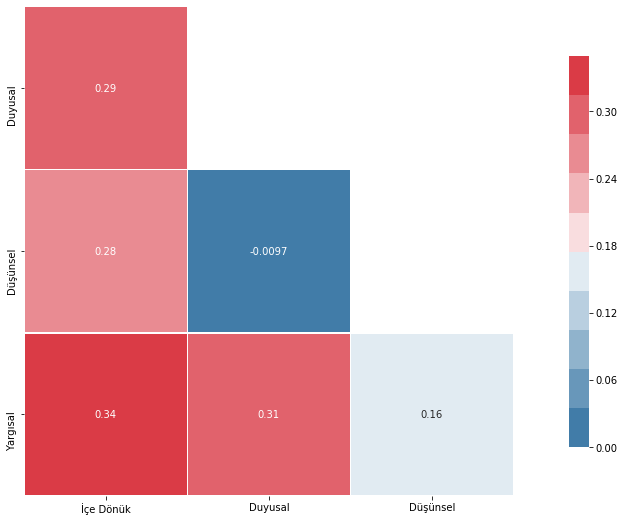

In [129]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=10)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax=.35, vmin = 0,
            square=True, linewidths=.5, annot = True, ax = ax, cbar_kws={"shrink": .8})
ax.set_ylim(4,1)
ax.set_xlim(0,3)
f.savefig("correlationsBetweenFactors.png")

<h3>HIGH CORRELATIONS BETWEEN:</h3>
<h4>Q28 and Q30, Q5 and Q12 - remove them? </h4>

In [131]:
answers = np.empty([32, 32])
questionTypes = [SCORETYPE.DUYUSAL, SCORETYPE.DUSUNSEL, SCORETYPE.ICEDONUK, SCORETYPE.YARGISAL]
 
for scoreType in questionTypes:
    predictors1, _ = getPredictorsAndPredictedForSpecificType(scoreType)
    predictors1 = np.asarray(predictors1)

    for questionNumber in range(8):
        globalQ1 = getQuestionNumberTotal(scoreType, questionNumber + 1)
        for otherQuestionNumber in range(8):
            corr = cramers_v(predictors1[questionNumber], predictors1[otherQuestionNumber])
            globalQ2 = getQuestionNumberTotal(scoreType, otherQuestionNumber + 1)
            answers[globalQ1 - 1][globalQ2 - 1] = corr
              

In [136]:
corrBetweenQuestions[5]

1    -0.068044
2    -0.062431
3    -0.018148
4    -0.058672
5     1.000000
6    -0.061142
7    -0.074936
8    -0.060902
9    -0.076582
10   -0.070117
11   -0.062468
12    0.567617
13   -0.065561
14   -0.058791
15   -0.078437
16   -0.063986
17   -0.067329
18   -0.068521
19   -0.079213
20    0.125783
21   -0.060086
22   -0.061353
23   -0.059587
24    0.214697
25    0.057680
26   -0.069390
27   -0.062342
28   -0.068311
29   -0.037970
30   -0.069992
31   -0.080908
32   -0.080127
Name: 5, dtype: float64

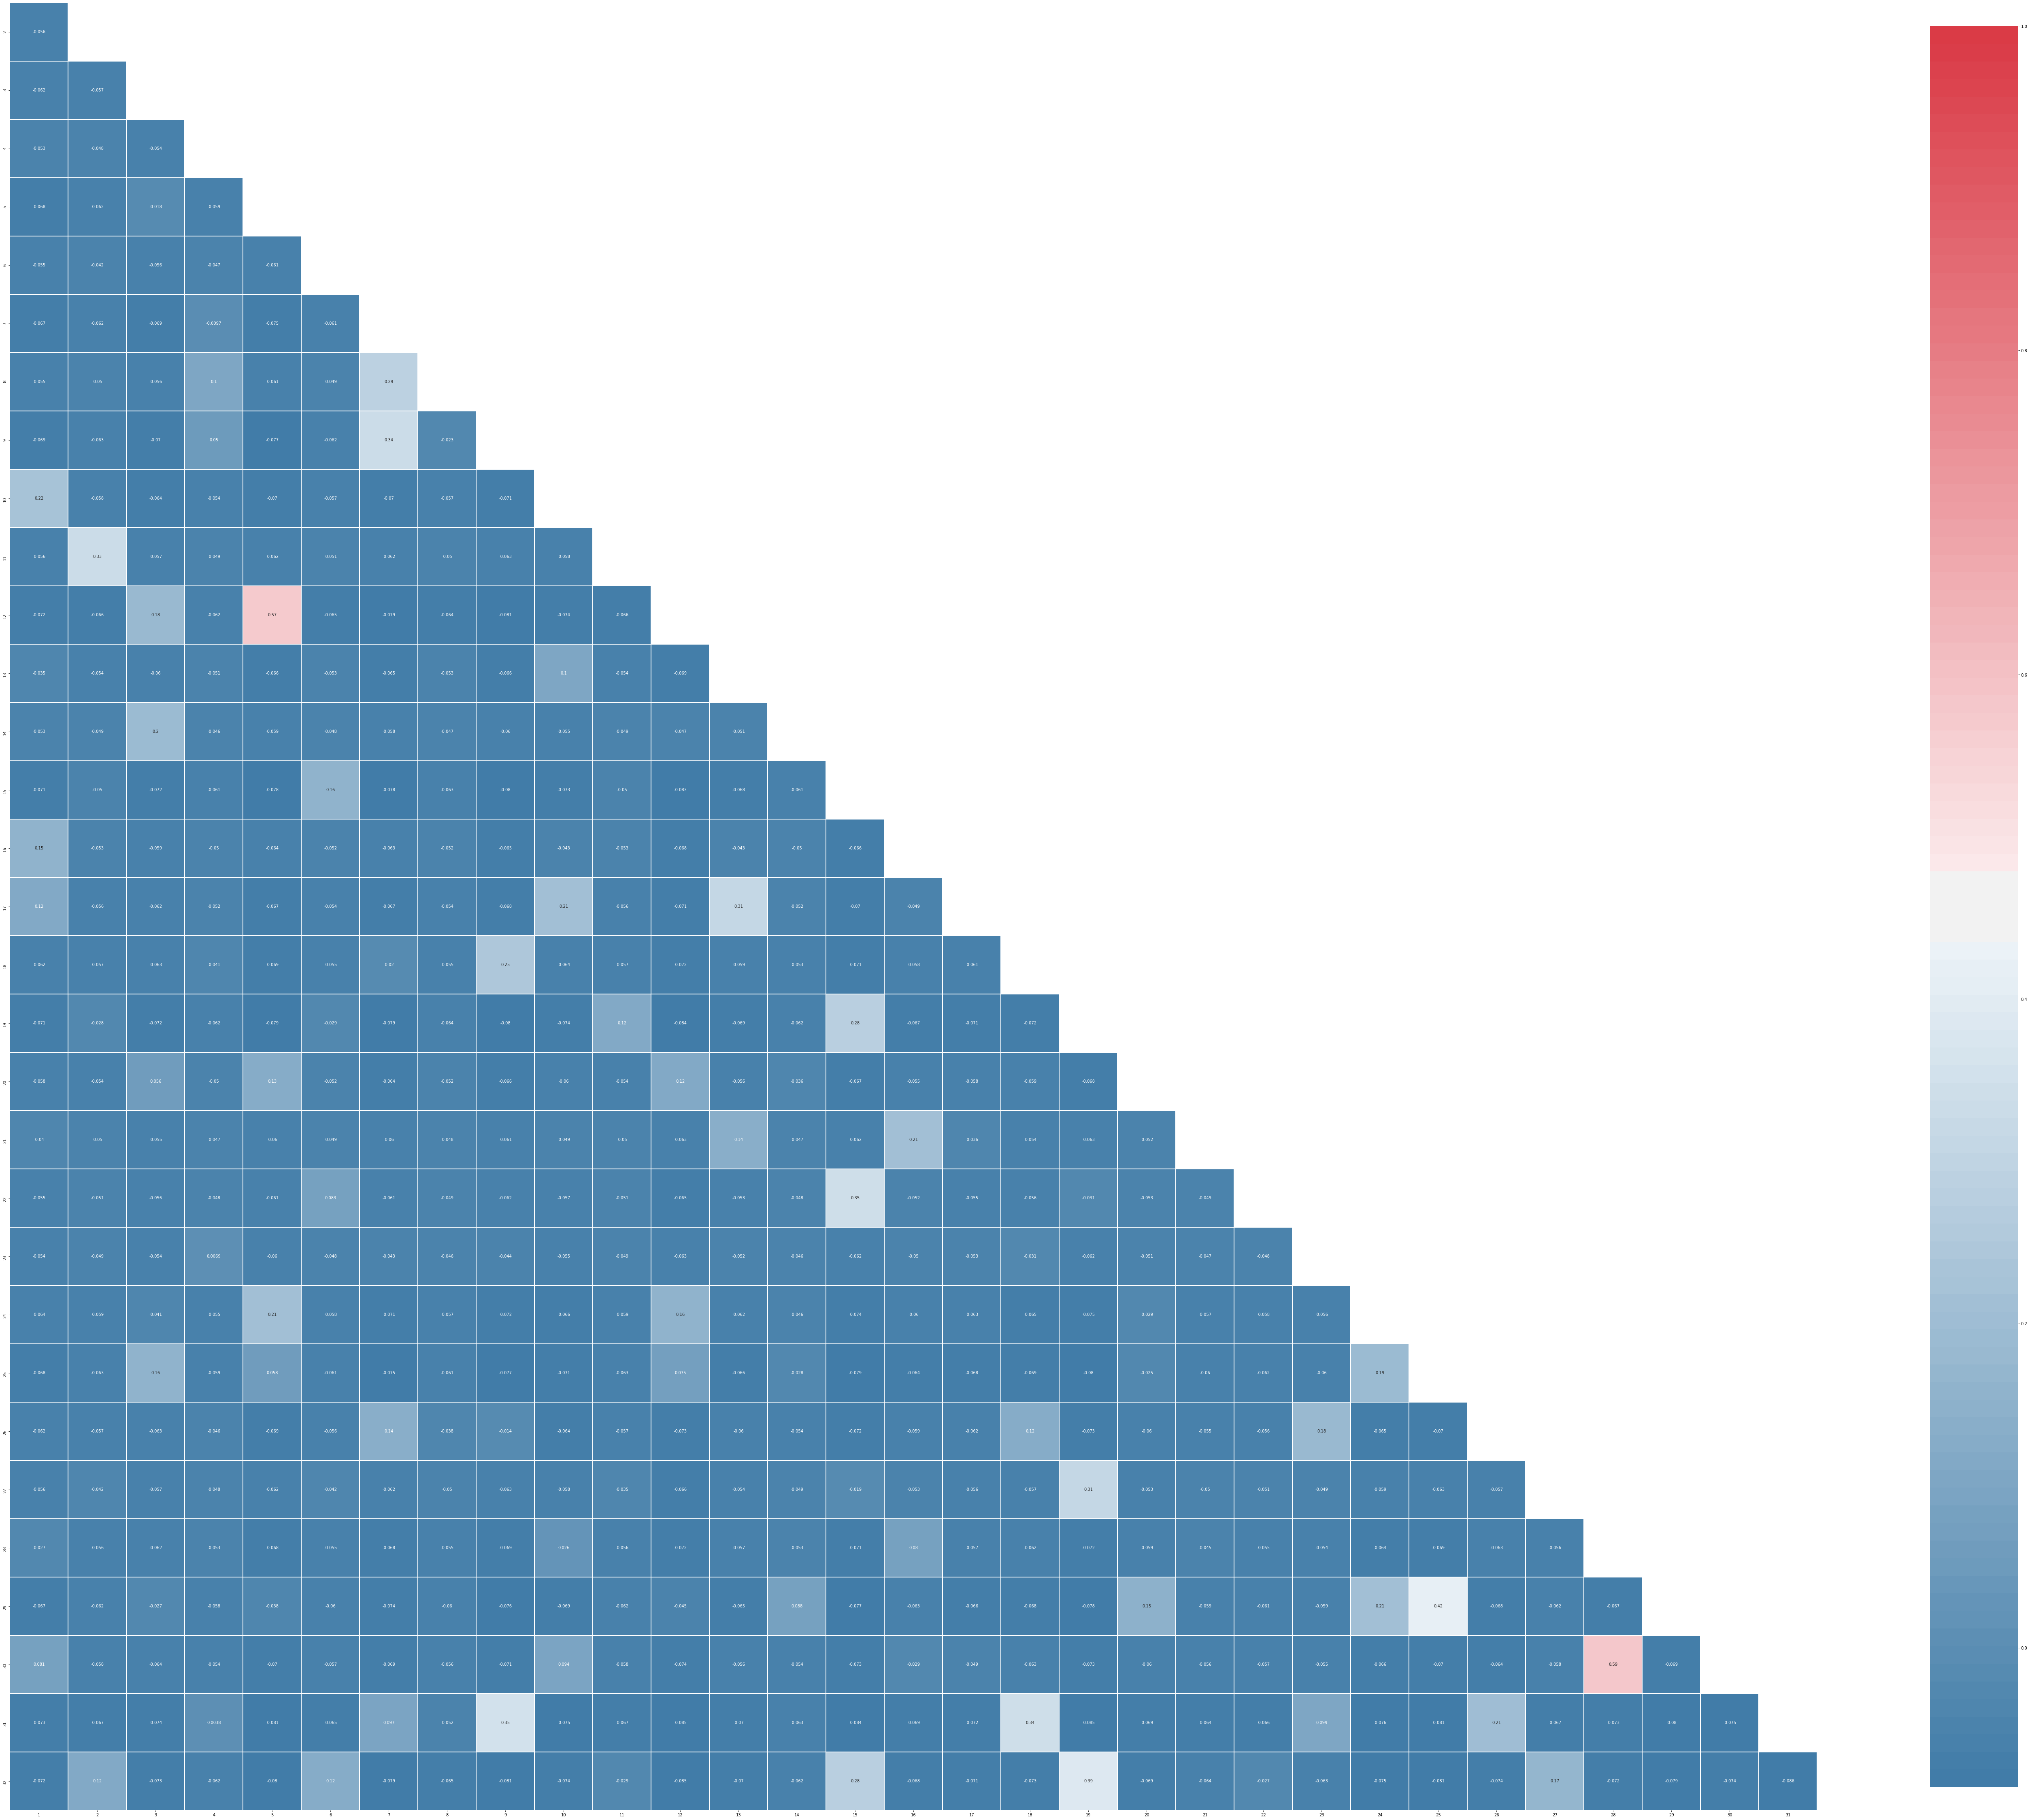

In [133]:
dfQuestions = pd.DataFrame(answers)
dfQuestions = dfQuestions.reindex(sorted(dfQuestions.columns), axis=1)

newColumnNames = []
for colName in sorted(dfQuestions.columns):
    newColumnNames.append(colName + 1)
    
dfQuestions.columns = newColumnNames
corrBetweenQuestions = dfQuestions.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corrBetweenQuestions, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(100, 100))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=100)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrBetweenQuestions, mask = mask, cmap = cmap,
            square=True, linewidths=.5, annot = True, ax = ax, cbar_kws={"shrink": .8})

ax.set_ylim(32,1)
ax.set_xlim(0,31)

f.savefig("correlationsBetweenQuestions.png")

In [57]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [56]:
def getPredictorsAndPredictedForSpecificType(questionType):
    predors = []
    preded = []
    for questionNumber in range(32):
        firstScoreType = answerSheet[questionNumber + 1][0]
        secondScoreType = answerSheet[questionNumber + 1][1]
        if (firstScoreType == questionType) or (secondScoreType == questionType):
            predors.append(findPredictors(questionNumber,firstScoreType, secondScoreType))
    preded = findPredictedByScoreType(questionType)
    return predors, preded

In [55]:
def getPredictorsForGender():
    predictors = []
    for row in range(data.shape[0]):
        if data["Gender"][row] == 0:
            predictors.append(0)
        else:
            predictors.append(1)
    return predictors

In [54]:
def findCorrelationBetweenQuestionAndScore(questionNumber, firstScoreType, secondScoreType):
    dataRowCount = data.shape[0]
    predictorsCorr = []
    predictedCorr = []

    predictorsCorr = findPredictors(questionNumber, firstScoreType, secondScoreType)
    predictedCorr = findPredictedByScoreType(firstScoreType)
    
    corrDf = pd.DataFrame({"Predicted" : predictedCorr, "Predictors" : predictorsCorr})
    return cramers_v(corrDf["Predicted"], corrDf["Predictors"])

In [112]:
def findPredictors(questionNumber, firstScoreType, secondScoreType):
    dataRowCount = data.shape[0]
    predictorsFind = []
    
    for rowNumber in range(dataRowCount):
        if data["Answer"][rowNumber][questionNumber].value == firstScoreType.value:
            predictorsFind.append(1)
        elif data["Answer"][rowNumber][questionNumber].value == secondScoreType.value:
            predictorsFind.append(0)

    return predictorsFind

In [119]:
def findPredictedByScoreType(firstScoreType):
    dataRowCount = data.shape[0]
    predictedScoreType = []
    secondScoreType = None
    
    if firstScoreType.value == SCORETYPE.ICEDONUK.value:
        secondScoreType = SCORETYPE.DISADONUK
    elif firstScoreType.value == SCORETYPE.DISADONUK.value:
        secondScoreType = SCORETYPE.ICEDONUK
    elif firstScoreType.value == SCORETYPE.DUYUSAL.value:
        secondScoreType = SCORETYPE.SEZGISEL
    elif firstScoreType.value == SCORETYPE.SEZGISEL.value:
        secondScoreType = SCORETYPE.DUYUSAL
    elif firstScoreType.value == SCORETYPE.DUSUNSEL.value:
        secondScoreType = SCORETYPE.DUYGUSAL
    elif firstScoreType.value == SCORETYPE.DUYGUSAL.value:
        secondScoreType = SCORETYPE.DUSUNSEL
    elif firstScoreType.value == SCORETYPE.YARGISAL.value:
        secondScoreType = SCORETYPE.ALGISAL
    elif firstScoreType.value == SCORETYPE.ALGISAL.value:
        secondScoreType = SCORETYPE.YARGISAL
    
    firstScoreLetter = getScoreLetter(firstScoreType)
    secondScoreLetter = getScoreLetter(secondScoreType)
    
    for rowNumber in range(dataRowCount):
        if firstScoreLetter in data["PType"][rowNumber]:        
            predictedScoreType.append(1)
        elif secondScoreLetter in data["PType"][rowNumber]:
            predictedScoreType.append(0)
    return predictedScoreType

In [51]:
#Function return Personality type by subject's row number
def getPersonalityType(rowNumber):
    iceDonukCounter = 0
    duyusalCounter = 0
    dusunselCounter = 0
    yargisalCounter = 0
    disaDonukCounter = 0
    sezgiselCounter = 0
    duygusalCounter = 0
    algisalCounter = 0

    for choice in range(len(data["Answer"][rowNumber])):
        if data["Answer"][rowNumber][choice] == SCORETYPE.ICEDONUK:
            iceDonukCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.DISADONUK:
            disaDonukCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.DUYUSAL:
            duyusalCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.SEZGISEL:
            sezgiselCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.DUSUNSEL:
            dusunselCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.DUYGUSAL:
            duygusalCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.YARGISAL:
            yargisalCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.ALGISAL:
            algisalCounter += 1

    personalityType = ""

    if iceDonukCounter > disaDonukCounter:
        personalityType += "Ç"
    else:
        personalityType += "Ş"

    if sezgiselCounter > duyusalCounter:
        personalityType += "S"
    else:
        personalityType += "D"

    if  duygusalCounter > dusunselCounter:
        personalityType += "U"
    else:
        personalityType += "Ü"

    if algisalCounter > yargisalCounter:
        personalityType += "A"
    else:
        personalityType += "Y"
    
    return personalityType

In [122]:
def getQuestionNumberTotal(scoreType, questionNumber):
    counter = 0
    factorwiseQuestionNumber = 0
    
    while (counter < 32):
        counter += 1
        if scoreType.value == answerSheet[counter][0].value or scoreType.value == answerSheet[counter][1].value:
            factorwiseQuestionNumber += 1
            if factorwiseQuestionNumber == questionNumber:
                return counter

In [123]:
answerSheet = {
    1 : [ SCORETYPE.SEZGISEL, SCORETYPE.DUYUSAL],
    2 : [ SCORETYPE.ICEDONUK, SCORETYPE.DISADONUK],
    3 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    4 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    5 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    6 : [ SCORETYPE.ICEDONUK, SCORETYPE.DISADONUK],
    7 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    8 : [ SCORETYPE.ALGISAL, SCORETYPE.YARGISAL],
    9 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    10 : [ SCORETYPE.SEZGISEL, SCORETYPE.DUYUSAL],
    11 : [ SCORETYPE.ICEDONUK, SCORETYPE.DISADONUK],
    12 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    13 : [ SCORETYPE.DUYUSAL, SCORETYPE.SEZGISEL],
    14 : [ SCORETYPE.DUYGUSAL, SCORETYPE.DUSUNSEL],
    15 : [ SCORETYPE.DISADONUK, SCORETYPE.ICEDONUK],
    16 : [ SCORETYPE.DUYUSAL, SCORETYPE.SEZGISEL],
    17 : [ SCORETYPE.DUYUSAL, SCORETYPE.SEZGISEL],
    18 : [ SCORETYPE.ALGISAL, SCORETYPE.YARGISAL],
    19 : [ SCORETYPE.DISADONUK, SCORETYPE.ICEDONUK],
    20 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    21 : [ SCORETYPE.DUYUSAL, SCORETYPE.SEZGISEL],
    22 : [ SCORETYPE.ICEDONUK, SCORETYPE.DISADONUK],
    23 : [ SCORETYPE.ALGISAL, SCORETYPE.YARGISAL],
    24 : [ SCORETYPE.DUYGUSAL, SCORETYPE.DUSUNSEL],
    25 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    26 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    27 : [ SCORETYPE.DISADONUK, SCORETYPE.ICEDONUK],
    28 : [ SCORETYPE.SEZGISEL, SCORETYPE.DUYUSAL],
    29 : [ SCORETYPE.DUYGUSAL, SCORETYPE.DUSUNSEL],
    30 : [ SCORETYPE.SEZGISEL, SCORETYPE.DUYUSAL],
    31 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    32 : [ SCORETYPE.DISADONUK, SCORETYPE.ICEDONUK]
}

In [124]:
def getScoreLetter(retrievedScoreType):
    scoreLetter = ""    
    if retrievedScoreType.value == SCORETYPE.ICEDONUK.value:
        scoreLetter = "Ç"
    elif retrievedScoreType.value == SCORETYPE.DISADONUK.value:
        scoreLetter = "Ş"
    elif retrievedScoreType.value == SCORETYPE.DUYUSAL.value:
        scoreLetter = "D"
    elif retrievedScoreType.value == SCORETYPE.SEZGISEL.value:
        scoreLetter = "S"
    elif retrievedScoreType.value == SCORETYPE.DUSUNSEL.value:
        scoreLetter = "Ü"
    elif retrievedScoreType.value == SCORETYPE.DUYGUSAL.value:
        scoreLetter = "U"
    elif retrievedScoreType.value == SCORETYPE.YARGISAL.value:
        scoreLetter = "Y"
    elif retrievedScoreType.value == SCORETYPE.ALGISAL.value:
        scoreLetter = "A"
    return scoreLetter